In [2]:
%%capture
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import Dataset
from torchvision import models
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tensorboardX import SummaryWriter

# Data Loading

In [27]:
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from PIL import Image
import torchvision.transforms as transforms

img_size = 512  # Size of the input images
# Training transformations
common_train_transform = A.Compose([
	#A.PadIfNeeded(min_height=284, min_width=284, border_mode=0),  
	A.Resize(img_size, img_size),  
	A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit= 20, p =0.5),
	A.CenterCrop(img_size, img_size, p=0.5),
	#A.Normalize(mean=[0.5], std=[0.5]),  # Normalize to [0,1] range
	#ToTensorV2(),
])

# Validation transformations
common_val_transform = A.Compose([
	#A.PadIfNeeded(min_height=284, min_width=284, border_mode=0),
	A.Resize(img_size, img_size),
	#A.Normalize(mean=[0.5], std=[0.5]),
	#ToTensorV2(),
])

# Normalization for images
transform_img = A.Compose([
	#A.Normalize(mean=[58.42], std=[51.01]),
	A.Normalize(mean=[0.5], std=[0.5]),
	ToTensorV2(),
])

# Transform mask: Convert to binary mask and tensor
transform_mask = A.Compose([
	#A.Lambda(image=lambda x: (x > 0).float()),  
	ToTensorV2(),
])


 # This dataset loader will be used for experiment with single image based (MR1 or MR2) model , where model is encoder(narrow) + fc regression model   
class ImageLoader_Dataset(Dataset):
	def __init__(
		self,
		root_dir="../../data/washu/Ovarian_Data_iq_process",
		response_dir="../../data/washu/PAT_imaging_record.xlsx",
		phase="train",
		img_transform=None,
		k_fold=5,
		fold=0,
	):
		self.root_dir = root_dir
		self.phase = phase
		self.img_transform = img_transform

		# Step 1: Read Excel sheet
		df = pd.read_excel(response_dir, sheet_name="ROI STATS V4 (3)")
		df = df.dropna(subset=["Patient ID", "Side", "GT"])
		df["Patient ID"] = df["Patient ID"].astype(int).astype(str).str.strip()
		df["Side"] = df["Side"].astype(str).str.strip()
		df["GT"] = pd.to_numeric(df["GT"], errors="coerce").astype("Int64")
		df = df.dropna(subset=["GT"])
		df["GT"] = df["GT"].astype(int)

		label_map = {
			("Patient_" + row["Patient ID"], row["Side"]): row["GT"]
			for _, row in df.iterrows()
		}

		# Step 2: Get all patient IDs and apply k-fold
		all_patient_ids = sorted([
			d for d in os.listdir(root_dir)
			if os.path.isdir(os.path.join(root_dir, d))
		])

		# kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
		# splits = list(kf.split(all_patient_ids))
		# train_idx, val_idx = splits[fold]

		if phase == 'train':
			selected_patient_ids = all_patient_ids # [all_patient_ids[i] for i in train_idx]
		else:
			selected_patient_ids = all_patient_ids # [all_patient_ids[i] for i in val_idx]


		# Step 3: Gather all samples
		all_samples = []
		for patient_id in selected_patient_ids:
			patient_path = os.path.join(root_dir, patient_id)
			for side in os.listdir(patient_path):
				side_path = os.path.join(patient_path, side)
				if not os.path.isdir(side_path):
					continue

				key = (patient_id, side)
				if key not in label_map:
					continue

				label = label_map[key]
				label = 1 if label == 0 else 0  # Optional: relabel if needed

				for fname in os.listdir(side_path):
					if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
						full_path = os.path.join(side_path, fname)
						if os.path.exists(full_path):
							all_samples.append((full_path, label))

		self.data = all_samples
			
	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, index):
		image_path, response = self.data[index]

		# Load image and mask as grayscale NumPy arrays
		image = np.array(Image.open(image_path).convert('L'))

		# Apply the corresponding transformations
		if self.phase == 'train':
			transformed = common_train_transform(image=image)
		else:
			transformed = common_val_transform(image=image)

		slice_image = transformed['image']
		# Apply additional transformations if provided
		if self.img_transform:
			slice_image = self.img_transform(image=slice_image)['image'].to(torch.float32)
			slice_image =  slice_image #transforms.functional.normalize(slice_image, mean=34.80, std= 42.51)

		return slice_image, torch.tensor(response, dtype=torch.float32), image_path

c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
from torch.utils.data import DataLoader

In [29]:
testDataset =  ImageLoader_Dataset(phase = 'test', img_transform= transform_img)
batch_size = 1
num_workers = 0
drop_last = False 
test_dataloader = DataLoader(
            testDataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last= drop_last,
            #persistent_workers=True,
        )

Feature batch shape: torch.Size([1, 1, 512, 512])
Masks batch shape: torch.Size([1])


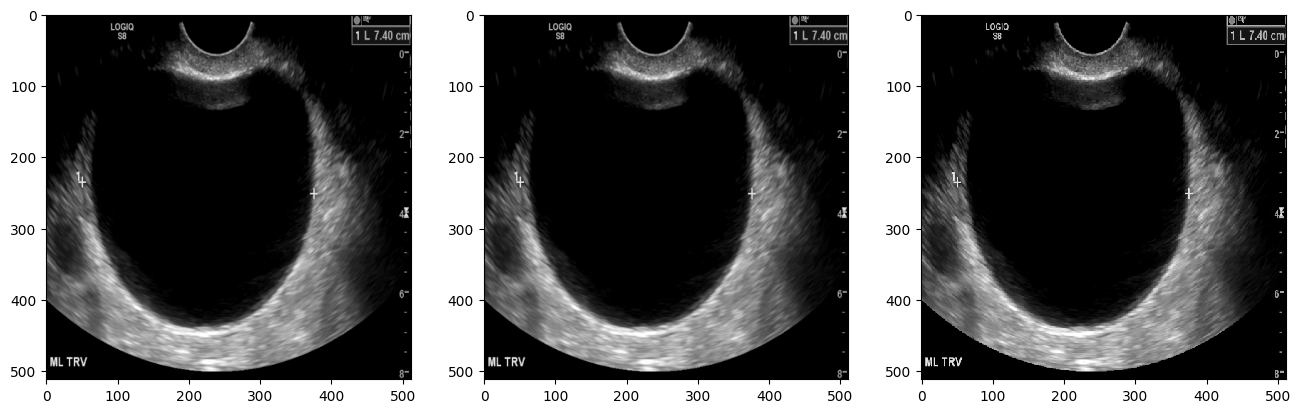

In [30]:
train_features, train_masks, image_path = next(iter(test_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

img = train_features[0].squeeze()
# mask = train_masks[0].squeeze()
# img_mask = np.ma.masked_where(mask == 0, mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
# ax[2].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

In [31]:
# %%capture
# !pip install -U segmentation-models-pytorch
# !pip install tqdm

In [32]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

In [33]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model_path = "../../checkpoints/deeplabv3/model_20250522_125038_49"
print("Best model saved to: ", model_path)
model.load_state_dict(torch.load(model_path))  
model.to(device)
model.eval()

Using device: cuda
Best model saved to:  ../../checkpoints/deeplabv3/model_20250522_125038_49


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## Visualizing results

In [35]:
validation_dataset = testDataset 

In [36]:
with torch.no_grad():
    for i in tqdm(range(len(validation_dataset))):
        image, mask, image_path = validation_dataset[i]
        image = image.unsqueeze(0).to(device)
        prediction = model(image)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze().cpu().numpy()
        predicted_mask = (predicted_mask > 0).astype(np.uint8)

        image = image.squeeze().cpu().numpy()

        save_path_image = image_path.replace("Ovarian_Data_iq_process", "Ovarian_Data_iq_process/Images")
        save_path_mask = image_path.replace("Ovarian_Data_iq_process", "Ovarian_Data_iq_process/Masks")
        os.makedirs(os.path.dirname(save_path_image), exist_ok=True)
        os.makedirs(os.path.dirname(save_path_mask), exist_ok=True)
        Image.fromarray((image * 255).astype(np.uint8)).save(save_path_image)  
        Image.fromarray((predicted_mask * 255).astype(np.uint8)).save(save_path_mask)
        print(f"Saved image to {save_path_image} and mask to {save_path_mask}")
        

  2%|▏         | 7/400 [00:00<00:12, 31.26it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4608-5y6zif.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4608-5y6zif.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4864-6e50px.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4864-6e50px.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5376-6wa8aw.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5376-6wa8aw.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5632-7qiwxs (1).png and mask to ../../data/washu/Ovaria

  4%|▍         | 15/400 [00:00<00:12, 31.23it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6400-99icak_left.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6400-99icak_left.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6656-17oj7lh.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6656-17oj7lh.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7168-18rklq6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7168-18rklq6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7424-19l9hrp.png and mask to ../../data/w

  5%|▍         | 19/400 [00:00<00:12, 30.67it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-9984-339480.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-9984-339480.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3072-1qo3thf.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3072-1qo3thf.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3328-1qsi68c_right.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3328-1qsi68c_right.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3584-1roe8nb.png and mask to ../../data

  6%|▋         | 26/400 [00:00<00:13, 28.55it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-9472-1psn7cn.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-9472-1psn7cn.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-1536-18rxi73.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-1536-18rxi73.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-2560-1myqdg9.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-2560-1myqdg9.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-3328-1rrnnjy.png and mask to ../../data/washu/Ova

  8%|▊         | 32/400 [00:01<00:13, 27.73it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-5888-1injiku.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-5888-1injiku.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-6400-1j5oq5t_left.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-6400-1j5oq5t_left.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-8960-1wuf3ao.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-8960-1wuf3ao.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-9472-b1gv6c_left.png and mask to ../../

 10%|▉         | 38/400 [00:01<00:13, 26.99it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3840-ne0nxu_right.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3840-ne0nxu_right.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-5376-12zyedn.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-5376-12zyedn.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_104\L\1.2.840.114350.2.456.2.798268.2.77101887.1-1-7168-31flsb_left.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_104\L\1.2.840.114350.2.456.2.798268.2.77101887.1-1-7168-31flsb_left.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_104\R\1.2.840.114350.2.456.2.798268.2.77101887.1-1-4352-1kztoct_right.png and mask to

 12%|█▏        | 46/400 [00:01<00:11, 31.51it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-2304-b246bc.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-2304-b246bc.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-2560-b39ogo.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-2560-b39ogo.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3072-b5jesa.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3072-b5jesa.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3840-bkxnf2.png and mask to ../../

 12%|█▎        | 50/400 [00:01<00:10, 32.76it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-5120-1a74exl.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-5120-1a74exl.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5376-1ajr1le.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5376-1ajr1le.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5888-1alfpd6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5888-1alfpd6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-6144-1amgqlt.png and mask to

 14%|█▍        | 58/400 [00:01<00:10, 32.17it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-1024-184rp06.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-1024-184rp06.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10240-1jkdo6k.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10240-1jkdo6k.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10496-5eedy.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10496-5eedy.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-11264-h0ams3.png and mask to ../../data/washu/Ova

 16%|█▋        | 66/400 [00:02<00:11, 29.73it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-2816-1hjwer4.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-2816-1hjwer4.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3072-1iz19xq.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3072-1iz19xq.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3328-1jg2wby.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3328-1jg2wby.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3584-1uc47eg.png and mask to ../../data/washu/Ova

 18%|█▊        | 73/400 [00:02<00:11, 27.56it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5376-plvyok.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5376-plvyok.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5632-cai2nh.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5632-cai2nh.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5888-qywcvj.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5888-qywcvj.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-6144-1l9s640.png and mask to ../../data/washu/Ovarian_D

 20%|█▉        | 79/400 [00:02<00:11, 27.35it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-768-176og7r.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-768-176og7r.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4096-qqjln6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4096-qqjln6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4352-qso82j.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4352-qso82j.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4608-1sl9n8o.png and mask to ../../data/washu/Ovarian_D

 20%|██        | 82/400 [00:02<00:11, 27.93it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-39-q0is9d.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-39-q0is9d.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-2560-pvqhf9.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-2560-pvqhf9.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-3072-q9xaxj.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-3072-q9xaxj.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_112\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-35-1h52pwy.png and mask to ../../data/washu/Ovarian_Data_iq

 22%|██▏       | 89/400 [00:03<00:10, 28.39it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-8192-u0vhsc_left_transvaginal.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-8192-u0vhsc_left_transvaginal.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-4864-1gyh05k.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-4864-1gyh05k.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5120-1v5tnzf.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5120-1v5tnzf.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5376-1vmvadn.pn

 24%|██▍       | 96/400 [00:03<00:10, 29.10it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6400-1ygs9xk.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6400-1ygs9xk.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6656-drgqv.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6656-drgqv.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6912-dn0vsc.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6912-dn0vsc.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-7168-el44kr.png and mask to ../../data/washu/Ovarian_Da

 26%|██▌       | 103/400 [00:03<00:10, 28.27it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5376-18fo9be.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5376-18fo9be.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5632-1a93rxe.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5632-1a93rxe.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-6656-1l9jfrg.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-6656-1l9jfrg.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_119\L\1.2.840.114350.2.456.2.798268.2.562053740.1-1-6144-zm0emf.png and mask to ../../data/washu/Ovar

 28%|██▊       | 110/400 [00:03<00:10, 28.91it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5632-m03px1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5632-m03px1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8192-1vwx9le.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8192-1vwx9le.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8448-7sebaq.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8448-7sebaq.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8704-95vsp9 (1).png and mask to ../../data/washu/Ovar

 30%|██▉       | 118/400 [00:04<00:09, 31.09it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3072-1sbkvx5.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3072-1sbkvx5.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3840-6wxb8t.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3840-6wxb8t.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-4096-70rved.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-4096-70rved.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-4352-9ap7t7.png and mask to ../../data/washu/Ovarian_

 31%|███▏      | 125/400 [00:04<00:09, 28.04it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1280-z1dsbk.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1280-z1dsbk.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1536-z1v0yu.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1536-z1v0yu.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-3072-zgq3zv.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-3072-zgq3zv.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-4608-zklb53.png and mask to ../../data/washu/Ovarian_Da

 33%|███▎      | 131/400 [00:04<00:09, 27.04it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5376-zxr3fd.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5376-zxr3fd.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-7168-1bsxyi3.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-7168-1bsxyi3.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-7680-1bu3go1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-7680-1bu3go1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-8704-1e8h2sf.png and mask to ../../data/washu/Ovari

 34%|███▍      | 137/400 [00:04<00:09, 27.40it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-3584-17fkrfg.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-3584-17fkrfg.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4096-1sbhecy.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4096-1sbhecy.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4352-xj77we.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4352-xj77we.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4608-1uocri1.png and mask to ../../data/washu/Ovari

 35%|███▌      | 141/400 [00:04<00:09, 28.12it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10240-hai27g.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10240-hai27g.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10496-i3n5nm.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10496-i3n5nm.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11008-jjvm0z.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11008-jjvm0z.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11520-19k98m9.png and mask to ../../data/washu/Ovarian_D

 37%|███▋      | 148/400 [00:05<00:08, 28.01it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9216-3z1gsg.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9216-3z1gsg.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9472-4efpel.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9472-4efpel.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9728-4gmvs2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9728-4gmvs2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9984-5sgzei.png and mask to ../../data/washu/Ovarian_Data_iq_p

 38%|███▊      | 154/400 [00:05<00:09, 27.15it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5888-g1nnc1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5888-g1nnc1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-6144-vo56ch.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-6144-vo56ch.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1280-1msgojn.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1280-1msgojn.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1536-1n9iaxv.png and mask to ../../data/washu/Ovarian

 40%|████      | 160/400 [00:05<00:08, 27.68it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2048-dr243l.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2048-dr243l.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2304-sfgebn.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2304-sfgebn.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2560-16mt263.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2560-16mt263.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2816-18xjybh.png and mask to ../../data/washu/Ovarian

 42%|████▏     | 166/400 [00:05<00:08, 27.09it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1024-36iez8.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1024-36iez8.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1536-kp6fl2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1536-kp6fl2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1792-u4b5b9.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1792-u4b5b9.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-2048-2ncbm2.png and mask to ../../data/washu/Ovarian_Da

 43%|████▎     | 173/400 [00:06<00:08, 27.59it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3072-cmuwmm.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3072-cmuwmm.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3328-pw4bo3.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3328-pw4bo3.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4096-1k4ix3l.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4096-1k4ix3l.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4352-1hpj2yx.png and mask to ../../data/washu/Ovarian

 44%|████▍     | 177/400 [00:06<00:07, 28.52it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3840-175mo8x.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3840-175mo8x.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4096-1o792fy.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4096-1o792fy.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4864-2f1op0.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4864-2f1op0.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5376-azfeix.png and mask to ../../data/washu/Ovaria

 46%|████▌     | 184/400 [00:06<00:07, 28.26it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4864-11922on.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4864-11922on.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5120-119klaz.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5120-119klaz.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5376-119n594.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5376-119n594.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-2816-zsqfcw.png and mask to ../../data/washu/Ovar

 48%|████▊     | 190/400 [00:06<00:07, 27.73it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3584-ztx7hc.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3584-ztx7hc.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4096-zv2pmp.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4096-zv2pmp.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4352-zvjbb1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4352-zvjbb1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4608-10adrbt.png and mask to ../../data/washu/Ovarian_D

 50%|████▉     | 198/400 [00:06<00:06, 29.47it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_44\R\1.2.840.114350.2.456.2.798268.2.415399654.1-1-4096-fbsxe1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_44\R\1.2.840.114350.2.456.2.798268.2.415399654.1-1-4096-fbsxe1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_44\R\IH1.2.840.114350.2.456.2.798268.2.415399654.1-1-3072-40wfzf.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_44\R\IH1.2.840.114350.2.456.2.798268.2.415399654.1-1-3072-40wfzf.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2048-107ehjs.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2048-107ehjs.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2816-1hq2ztf.png and mask to ../../data/washu/Ovarian_Da

 51%|█████     | 204/400 [00:07<00:07, 27.93it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-4352-ftrra5.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-4352-ftrra5.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-6144-1kvhlan.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-6144-1kvhlan.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1280-1n5nxq7.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1280-1n5nxq7.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1792-1k9mha2.png and mask to ../../data/washu/Ovarian_Data

 52%|█████▎    | 210/400 [00:07<00:07, 25.97it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw (1).png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw (1).png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2560-ssnnlm.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2560-ssnnlm.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2816-u7sis9.png and mask to ../../data/washu/Ovarian_D

 54%|█████▎    | 214/400 [00:07<00:06, 27.64it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-4352-1ko6wl7.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-4352-1ko6wl7.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\L\1.2.840.114350.2.456.2.798268.2.421071450.1-1-1792-ct1yab.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_47\L\1.2.840.114350.2.456.2.798268.2.421071450.1-1-1792-ct1yab.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2048-su00ii.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2048-su00ii.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2304-18gispg.png and mask to ../../data/washu/Ovarian_Data_i

 55%|█████▌    | 221/400 [00:07<00:06, 27.68it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3072-vlujqw.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3072-vlujqw.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3328-aq4lt8.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3328-aq4lt8.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3584-1yuepgk.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3584-1yuepgk.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3840-1ph52a.png and mask to ../../data/washu/Ovarian_Data_iq

 57%|█████▋    | 228/400 [00:08<00:06, 28.32it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-7424-100xm92_right.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-7424-100xm92_right.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-8960-16ga8dl.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-8960-16ga8dl.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-2304-548jfz.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-2304-548jfz.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-2816-19sgt8.png and mask to ../../data/washu/O

 59%|█████▉    | 236/400 [00:08<00:05, 31.66it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-4096-1raphxm.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-4096-1raphxm.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-4352-51t8ls.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-4352-51t8ls.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-5120-3kg37h.png and mask to ../../data/washu/Ovarian_Data_

 61%|██████    | 244/400 [00:08<00:04, 33.41it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5888-1miani6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5888-1miani6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5888-r5ilqp.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5888-r5ilqp.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-1ytgtr9.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-1ytgtr9.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-jttqkt.png and mask to ../../data/washu/Ovarian_Data_

 62%|██████▏   | 248/400 [00:08<00:04, 33.43it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_54\L\closer_to_PA_recordered.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_54\L\closer_to_PA_recordered.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2048-193469w.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2048-193469w.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2304-1imnc6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2304-1imnc6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2560-4ty046.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\L\1.2.840.114350.2.456.2.798268.2.43620302

 64%|██████▍   | 256/400 [00:08<00:04, 30.17it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-1536-jkgb4z.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-1536-jkgb4z.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-256-edb5fl.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-256-edb5fl.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5376-f4orj2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5376-f4orj2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5632-xlg0wp.png and mask to ../../data/washu/Ovarian_Data_iq_pro

 66%|██████▌   | 264/400 [00:09<00:04, 32.08it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_63\R\217SRightOvary.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_63\R\217SRightOvary.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_64\R\XXX_XXX.US.XXX_XXX.1.1536.19000101.120000.ry08xt.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_64\R\XXX_XXX.US.XXX_XXX.1.1536.19000101.120000.ry08xt.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb (1).png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb (1).png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb.png
Saved image to ../../data/washu/Ovarian_Data

 67%|██████▋   | 268/400 [00:09<00:04, 31.69it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\L\XXX_XXX.US.XXX_XXX.1.6912.19000101.120000.ry3ise.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\L\XXX_XXX.US.XXX_XXX.1.6912.19000101.120000.ry3ise.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\L\XXX_XXX.US.XXX_XXX.1.7424.19000101.120000.ry423d.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\L\XXX_XXX.US.XXX_XXX.1.7424.19000101.120000.ry423d.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\L\XXX_XXX.US.XXX_XXX.1.7936.19000101.120000.ry45tr.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\L\XXX_XXX.US.XXX_XXX.1.7936.19000101.120000.ry45tr.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\L\XXX_XXX.US.XXX_XXX.1.8448.19000101.120000.ry4p4q.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\L\XXX_XXX.US.XXX_XXX.1.8448.19000101.12

 69%|██████▉   | 276/400 [00:09<00:04, 30.12it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (2).png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (2).png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (1).png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (1).png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (2).png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_65\R\XXX_XXX.US.XXX_XX

 71%|███████   | 284/400 [00:09<00:03, 30.18it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_66\L\XXX_XXX.US.XXX_XXX.1.3584.19000101.120000.ry1j14.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_66\L\XXX_XXX.US.XXX_XXX.1.3584.19000101.120000.ry1j14.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_66\L\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_66\L\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\L\left_ovary1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\L\left_ovary1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\L\right_ovary1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\L\right_ovary1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\L\XXX_XXX.US.XXX_XXX.2.2048.19000101.120000.ry0s8s.png a

 72%|███████▏  | 288/400 [00:09<00:03, 29.35it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\L\XXX_XXX.US.XXX_XXX.2.2560.19000101.120000.ry0vzr.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\L\XXX_XXX.US.XXX_XXX.2.2560.19000101.120000.ry0vzr.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\right_ovary2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\right_ovary2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\right_ovary3.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\right_ovary3.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\right_ovary34.jpg and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\right_ovary34.jpg
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\right_ovary4.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\right_ovary4.png
Saved image to .

 74%|███████▎  | 294/400 [00:10<00:03, 28.18it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3328.19000101.120000.ry1heo.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3328.19000101.120000.ry1heo.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3584.19000101.120000.ry1j14.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3584.19000101.120000.ry1j14.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3840.19000101.120000.ry1l5n.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\XXX_XXX.US.XXX_XXX.2.3840.19000101.120000.ry1l5n.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_67\R\XXX_XXX.US.XXX_XXX.2.4096.19000101.120000.ry22c3.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_67\R\XXX_XXX.US.XXX_XXX.2.4096.19000101.12

 76%|███████▌  | 303/400 [00:10<00:03, 31.61it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_68\L\left_ovary4.jpg and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_68\L\left_ovary4.jpg
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_68\L\right_ovary4.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_68\L\right_ovary4.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_68\R\right_ovary1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_68\R\right_ovary1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_68\R\right_ovary2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_68\R\right_ovary2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_68\R\XXX_XXX.US.XXX_XXX.1.512.19000101.120000.rx4yj4_right.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_68\R\XXX_XXX.US.XXX_XXX.1.512.19000101.120000.rx4yj4_right.png
Saved imag

 78%|███████▊  | 310/400 [00:10<00:03, 28.42it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_73\L\left_ovary2.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_73\L\left_ovary2.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_73\L\left_ovary_3_transabdominal.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_73\L\left_ovary_3_transabdominal.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh_transvaginal.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh_transvaginal.png
Saved image to ../../data/washu/Ov

 78%|███████▊  | 313/400 [00:10<00:03, 28.04it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5120-pwye8a.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5120-pwye8a.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5376-1vncpr6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5376-1vncpr6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-6400-9tup24.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-6400-9tup24.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\L\1.2.840.114350.2.456.2.798268.2.471683712.1-1-5888-1pf1ckc.png and mask to ../../data/washu/Ovarian_Data_i

 80%|███████▉  | 319/400 [00:11<00:02, 27.26it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\L\1.2.840.114350.2.456.2.798268.2.471683712.1-1-6656-26ego3.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\L\1.2.840.114350.2.456.2.798268.2.471683712.1-1-6656-26ego3.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3072-vnec2n.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3072-vnec2n.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3328-17ckqla.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3328-17ckqla.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3584-17fvi5h (1).png and mask to ../../data/washu/Ovarian_Da

 82%|████████▏ | 326/400 [00:11<00:02, 27.80it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4096-18rplry.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4096-18rplry.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4352-18w3yiv.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4352-18w3yiv.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4608-19tnepx.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4608-19tnepx.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-10496-1s4ggpg.png and mask to ../../data/washu/Ovarian_D

 83%|████████▎ | 332/400 [00:11<00:02, 27.58it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-4864-ay8yh5.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-4864-ay8yh5.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2560-1eio5ij.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2560-1eio5ij.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2816-1fui94z.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2816-1fui94z.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-3584-1r84z7o.png and mask to ../../data/washu/Ovarian_Data

 84%|████████▍ | 338/400 [00:11<00:02, 25.63it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4352-bby0zj.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4352-bby0zj.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4864-m92x8s.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4864-m92x8s.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5120-m9mpu6.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5120-m9mpu6.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5376-mp0ygb.png and mask to ../../data/washu/Ovarian_Data_iq_p

 86%|████████▌ | 344/400 [00:11<00:02, 27.03it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-1025-15a3er5.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-1025-15a3er5.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-1793-1uaqeoq.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-1793-1uaqeoq.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2305-1wswo0l.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2305-1wswo0l.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2561-9z4851.png and mask to ../../data/washu/Ovarian_Dat

 88%|████████▊ | 352/400 [00:12<00:01, 30.71it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4352-1dyqqqu.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4352-1dyqqqu.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4608-1e21ib1.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4608-1e21ib1.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4864-1eyhdbd.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4864-1eyhdbd.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-5376-1fy7zvw.png and mask to ../../data/washu/Ovarian_Da

 90%|█████████ | 360/400 [00:12<00:01, 31.95it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-7424-aqy4ru.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-7424-aqy4ru.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4096-c3gpva.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4096-c3gpva.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4608-c5oj8b.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4608-c5oj8b.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-5888-czz4tw.png and mask to ../../data/washu/Ovarian_Data_iq_p

 91%|█████████ | 364/400 [00:12<00:01, 32.28it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1024-b4ezqw.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1024-b4ezqw.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1536-b6m64z.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1536-b6m64z.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1792-b7nud5.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1792-b7nud5.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-2304-bkszna.png and mask to ../../data/washu/Ovarian_Data_iq_p

 93%|█████████▎| 372/400 [00:12<00:00, 31.34it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-7168-dy4xl4.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-7168-dy4xl4.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-768-b36xng.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-768-b36xng.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4352-1u6w8sd.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4352-1u6w8sd.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4608-1v2sb7c.png and mask to ../../data/washu/Ovarian_Data_iq_

 95%|█████████▌| 380/400 [00:13<00:00, 30.13it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-5632-1bpgugi.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-5632-1bpgugi.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2048-zbo12n.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2048-zbo12n.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2304-zgm6xl.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2304-zgm6xl.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2560-zxntbt.png and mask to ../../data/washu/Ovarian_Data_iq

 96%|█████████▌| 384/400 [00:13<00:00, 30.04it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4352-1wqhnp4.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4352-1wqhnp4.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4608-1dqkaxp.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4608-1dqkaxp.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4864-1v98bix.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4864-1v98bix.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-5120-omtl83.png and mask to ../../data/washu/Ovarian_Dat

 98%|█████████▊| 391/400 [00:13<00:00, 27.51it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5120-1w0hxn7.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5120-1w0hxn7.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5376-1wi3cms.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5376-1wi3cms.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5632-1xb8g3j.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5632-1xb8g3j.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5888-1ydq1mu.png and mask to ../../data/washu/Ovarian_Da

100%|█████████▉| 398/400 [00:13<00:00, 27.79it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-9728-1nvtoy8.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-9728-1nvtoy8.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-3328-oetgfz.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-3328-oetgfz.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4096-ptybn8.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4096-ptybn8.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4352-qag5g3.png and mask to ../../data/washu/Ovarian_Data_iq

100%|██████████| 400/400 [00:13<00:00, 28.92it/s]

Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5376-16b8bw0.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5376-16b8bw0.png
Saved image to ../../data/washu/Ovarian_Data_iq_process/Images\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5632-16r6d3i.png and mask to ../../data/washu/Ovarian_Data_iq_process/Masks\Patient_97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5632-16r6d3i.png


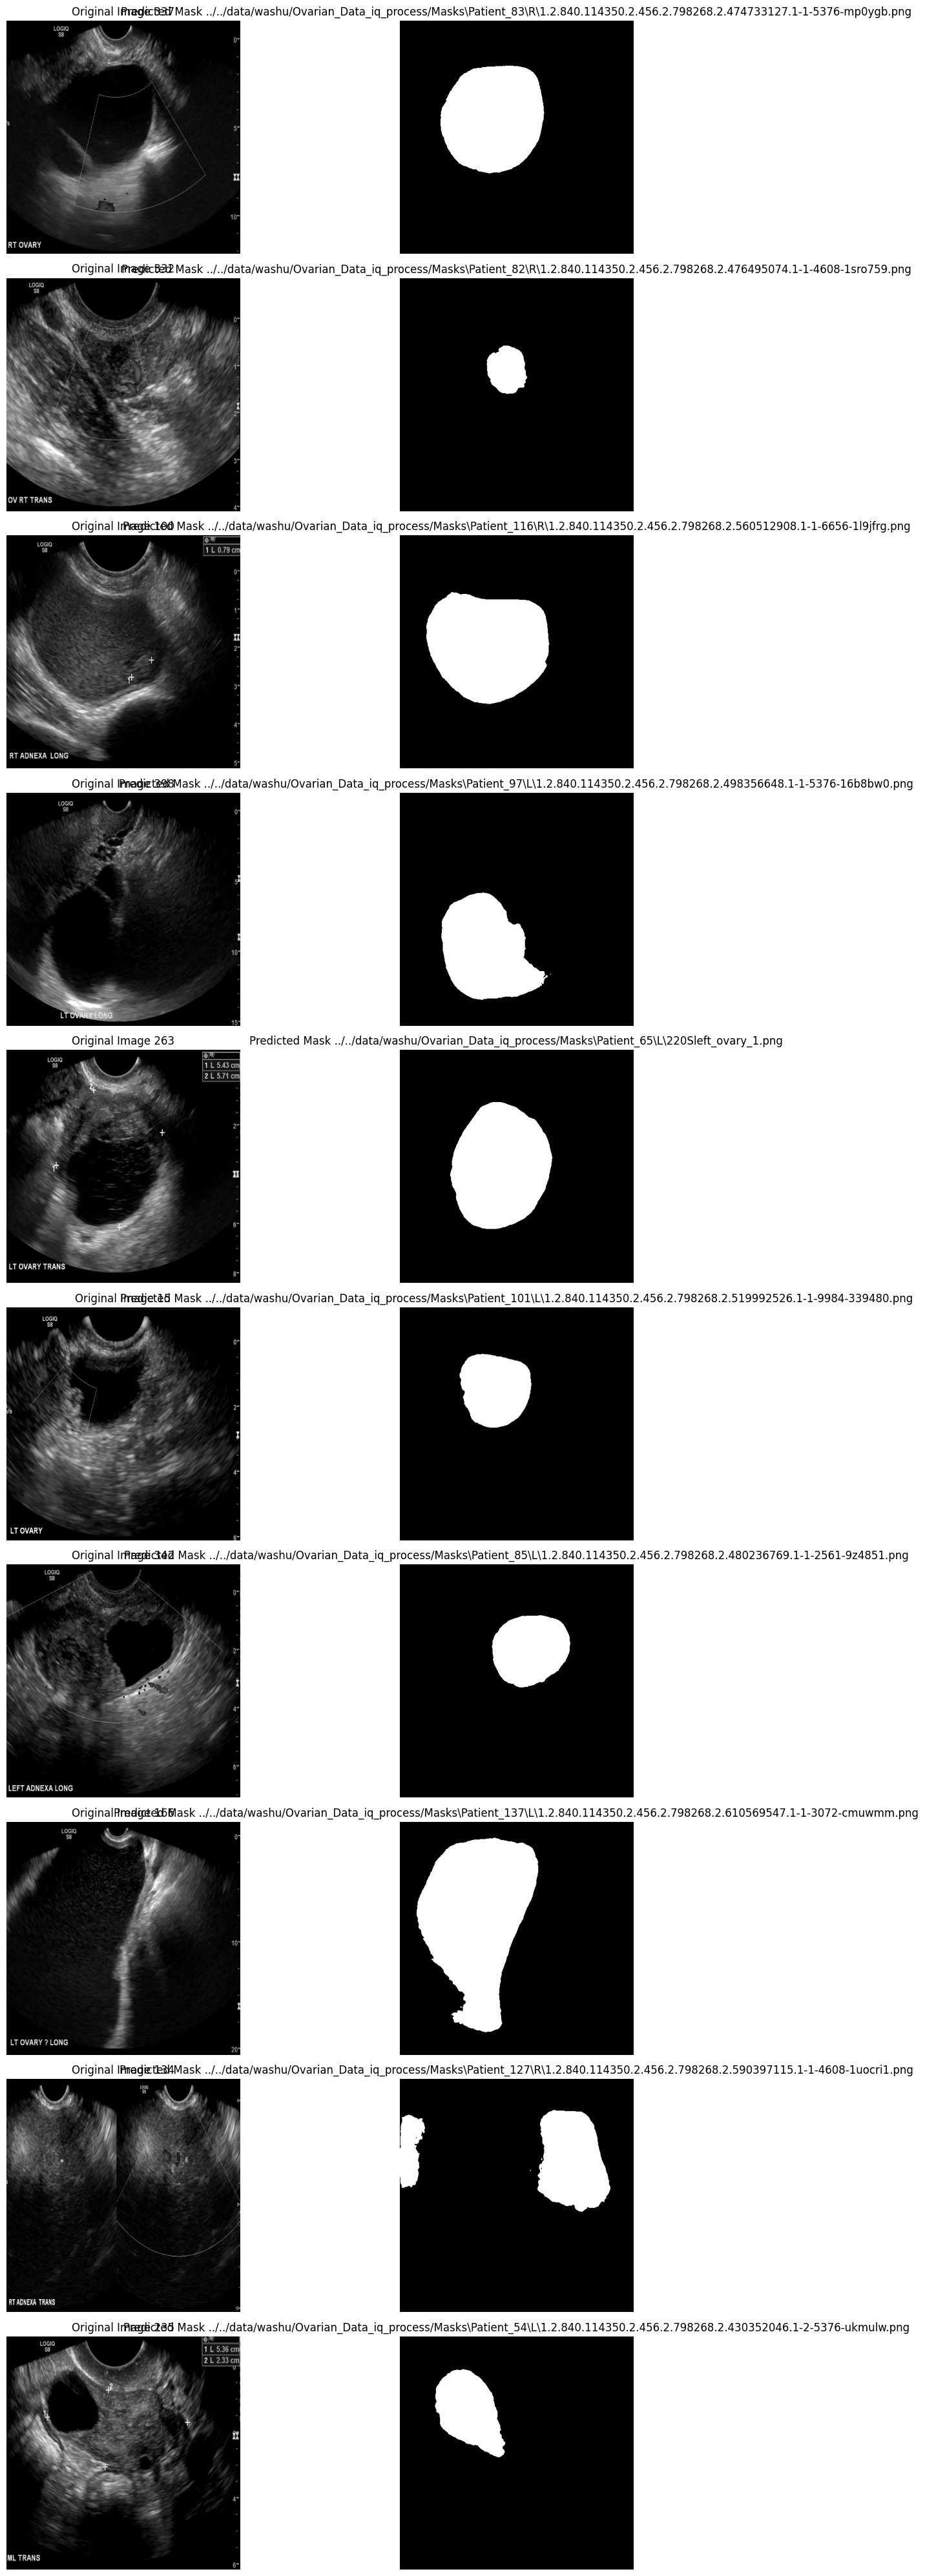

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation dataset
indices = torch.randperm(len(validation_dataset))[:10]

# Create a figure for plotting
fig, axs = plt.subplots(10, 2, figsize=(15, 40))  # 10 rows, 3 columns

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Get the ith sample
        image, true_mask, image_path = validation_dataset[idx]

        # Add batch dimension and transfer to the same device as model
        image_batch = image.unsqueeze(0).to(device)

        # Get model prediction
        prediction = model(image_batch)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu()

        # Convert tensors to numpy arrays for plotting
        image_np = image.squeeze().cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        predicted_mask_np = predicted_mask.numpy()

        # Plot original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image {idx}')

        # # Plot true mask
        # axs[i, 1].imshow(true_mask_np, cmap='gray')
        # axs[i, 1].axis('off')
        # axs[i, 1].set_title(f'True Mask {idx}')

        # Plot predicted mask
        axs[i, 1].imshow(predicted_mask_np, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'Predicted Mask {image_path.replace("Ovarian_Data_iq_process", "Ovarian_Data_iq_process/Masks")}')

plt.tight_layout()
plt.show()